In [3]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [4]:
path = '/Volumes/GoogleDrive/Shared drives/NIAAA_ASSIST/Data/PH2'
brain1 = 'AUD_AUDIT_report_for_researcher.xlsx'
brain2 = 'AUD_report_for_researcher.xlsx'
nih = 'NIH_Alcohol_CDEs.csv'

In [5]:
df_nih = pd.read_csv(os.path.join(path,nih))

In [6]:
df_nih.columns

Index(['Name', ' Question Texts', ' Value Type', ' Permissible Values',
       ' Nb of Permissible Values', ' Steward', ' Used By',
       ' Registration Status', ' Identifiers'],
      dtype='object')

In [7]:
len(df_nih)

441

In [27]:
from sentence_transformers import SentenceTransformer

2022-12-03 19:51:26.481486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def plot_featurized_images(vectorized_image,sc=None,params=None,df=None):
    '''
    Numpy array of images
    :param imgs: images of shape (batch,pixels) or (batch,pixels,num_channels)
    :param parameters to use for plot - like
    :param sc: Standard Scaler type
    :return: the standarad scaler
    '''

    if sc:
        vectorized_image = sc.transform(vectorized_image)
    else:
        sc = StandardScaler()
        vectorized_image = sc.fit_transform(vectorized_image)

    pca = PCA(n_components=3)
    data = pca.fit_transform(vectorized_image)
    print('Explained variance ratio',pca.explained_variance_ratio_)
    

    if params:
        sns.scatterplot(x=data[:,0],y=data[:,1],**params)
    else:
        sns.scatterplot(x=data[:,0],y=data[:,1])

    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Plot of Embedding vectors')
    if df is not None:
        df[['pc1','pc2','pc3']]=data
        return sc,df
    else:
        return sc

In [98]:
df_dist = dist.where(np.triu(np.ones(dist.shape)).astype(np.bool))
df_dist=pd.melt(df_dist,ignore_index=False,value_name='Sim')
df_dist.dropna(inplace=True)
df_dist.rename({'ModName':'Mod2'},axis=1,inplace=True)
df_dist.reset_index(inplace=True)
df_dist.rename({'ModName':'Mod1'},axis=1,inplace=True)

In [101]:
df_dist[(df_dist['Sim']>0.8)&(df_dist['Mod1']!=df_dist['Mod2'])].to_excel('NIAAA_CDE_sims.xlsx')

In [103]:
df_dist[(df_dist['Sim']<0.2)&(df_dist['Mod1']!=df_dist['Mod2'])].to_excel('NIAAA_CDE_diffs.xlsx')

In [233]:
sentences = df_nih['Name']
embeddings = model.encode(sentences)

In [307]:
def check_for_dash(row):
    if '-' in row and '(' in row:
        parens_list = row.split(')')
        dt = ')'.join(parens_list[:-1])
        dt = dt+')'
    elif 'PROMIS' in row:
        dt = 'PROMIS'
    else:
        dt = 'Free Text'
    return dt

In [308]:
df_nih['Vocab']=list(map(lambda s: check_for_dash(df_nih.loc[s,'Name']),df_nih.index))

In [309]:
df_nih['Vocab'].value_counts()

Free Text                                                                          190
PROMIS                                                                             109
Alcohol Smoking and Substance Use Involvement Screening Test (ASSIST)               80
Headache Screening Survey (HSS)                                                     25
Alcohol Use Disorders Identification Test (AUDIT)                                   11
Family History Research Diagnostic Criteria (FH-RDC)                                 4
Substance Abuse Questions from the TBI Model Systems Database (SAQTBIMSD)            4
Minnesota Multiphasic Personality Inventory - 2 - Restructured Form (MMPI-2-RF)      3
Longitudinal Interval Follow-Up Evaluation (LIFE)                                    2
Mayo-Portland Adaptability Inventory (MPAI-4)                                        2
Child Behavior Checklist (CBCL)                                                      2
UCLA PTSD Reaction Index DSM-5 (UCLA PTSD-R

Explained variance ratio [0.14357731 0.10584178 0.06132541]


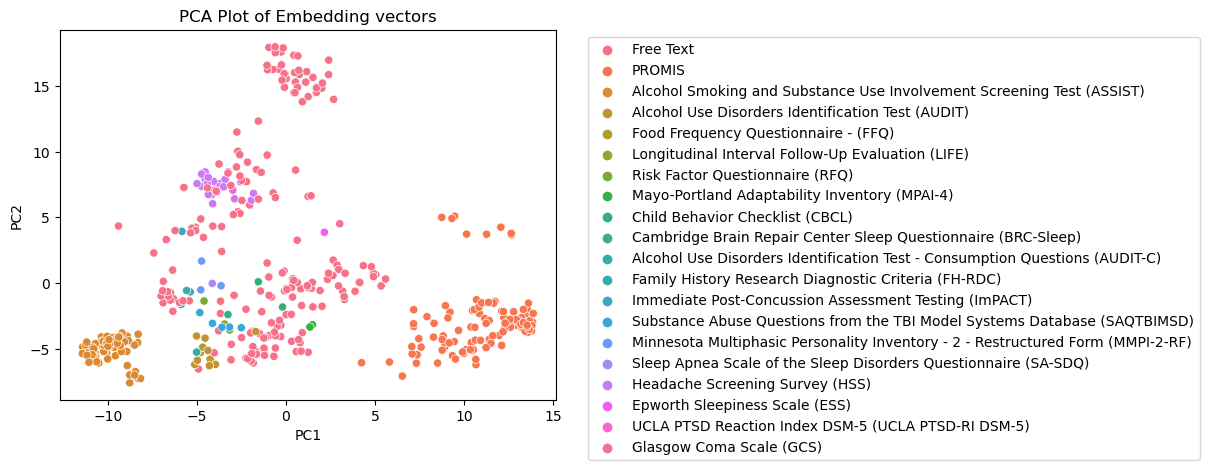

In [310]:
sc,df=plot_featurized_images(embeddings,params={'hue':df_nih['Vocab']},df=df_nih.copy())

In [311]:
dist = pd.DataFrame(1-pairwise_distances(embeddings,metric='cosine'),columns=df_nih['Name'],index=df_nih['Name'])

In [312]:
df_dist = dist.where(np.triu(np.ones(dist.shape)).astype(np.bool))
df_dist=pd.melt(df_dist,ignore_index=False,value_name='Sim')
df_dist.dropna(inplace=True)
df_dist.rename({'Name':'Mod2'},axis=1,inplace=True)
df_dist.reset_index(inplace=True)
df_dist.rename({'Name':'Mod1'},axis=1,inplace=True)

In [356]:
df_sub = df_dist.copy()
len(df_sub)

97461

In [357]:
df_sub.columns

Index(['Mod1', 'Mod2', 'Sim'], dtype='object')

In [358]:
df_sub = pd.merge(df_sub,df_nih[['Name','Vocab']],left_on='Mod1',right_on='Name')
df_sub = pd.merge(df_sub,df_nih[['Name','Vocab']],left_on='Mod2',right_on='Name')
df_sub.drop(['Name_x', 'Name_y'],axis=1,inplace=True)
df_sub.columns

Index(['Mod1', 'Mod2', 'Sim', 'Vocab_x', 'Vocab_y'], dtype='object')

In [364]:
df_sub['Match']='Prefex Match'
df_sub.loc[df_sub['Vocab_x']!=df_sub['Vocab_y'],'Match']='Prefix Not Match'
df_sub.loc[(df_sub['Vocab_x']=='Free Text')&(df_sub['Vocab_y']=='Free Text'),'Match']='No Prefix'


Text(0.5, 1.0, 'Harmonization of Mental Health Responses')

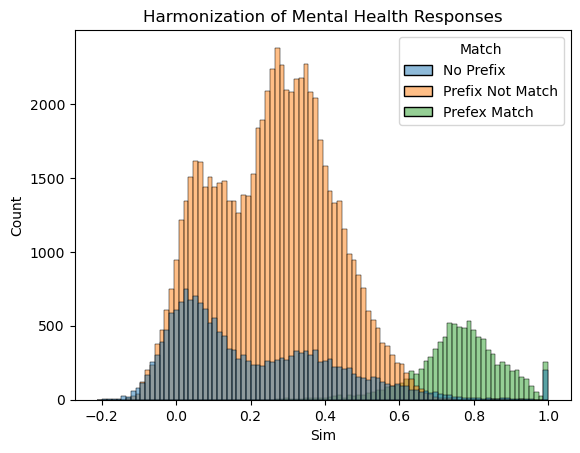

In [366]:
sns.histplot(data=df_sub,x='Sim',hue='Match')
plt.title('Harmonization of Mental Health Responses')

In [318]:
df_sub = df_sub[(df_sub['Sim']>0.6)&(df_sub['Mod1']!=df_sub['Mod2'])]
df_sub.to_excel('NIAAA_FullCDE_sims.xlsx')

In [303]:
df_sub.columns

Index(['Mod1', 'Mod2', 'Sim', 'Vocab_x', 'Vocab_y', 'Match'], dtype='object')

In [331]:
def modname(row):
    if row['Vocab']=='Free Text':
        return row['Name']
    else:
        if ')' in row['Name']:
            return row['Name'].replace(row['Vocab']+' - ','')
        else:
            return row['Name'].replace(row['Vocab']+ ' - ','')

# list(map(lambda s: modname(df_nih.loc[s,['Name','Vocab']]),[5]))
df_nih['ModName'] = list(map(lambda s: modname(df_nih.loc[s,['Name','Vocab']]),df_nih.index))

In [333]:
df_nih[df_nih['Vocab']!='Free Text'].head(10)

,Name,Question Texts,Value Type,Permissible Values,Nb of Permissible Values,Steward,Used By,Registration Status,Identifiers,Vocab,ModName
1,PROMIS - Alcohol use had craving for alcohol s...,NaN,Value List,1; 2; 3; 4; 5,5,NINDS,NINDS,Qualified,NINDS: C55183 v1; BRICS Variable Name: PROMISA...,PROMIS,Alcohol use had craving for alcohol scale
6,PROMIS - Alcohol use alcohol other drug use to...,NaN,Value List,1; 2; 3; 4; 5,5,NINDS,NINDS,Qualified,NINDS: C55171 v1; BRICS Variable Name: PROMISA...,PROMIS,Alcohol use alcohol other drug use together scale
12,Alcohol Smoking and Substance Use Involvement ...,NaN,Value List,0; 2; 3; 4; 6,5,NINDS,NINDS,Qualified,BRICS Variable Name: ASSISTAlcoholicBeverageFr...,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage frequency
14,Alcohol Use Disorders Identification Test (AUD...,NaN,Value List,0; 1; 2; 3; 4,5,NINDS,NINDS; NINR,Qualified,BRICS Variable Name: AUDITDrnkContainAlcFreqSc...,Alcohol Use Disorders Identification Test (AUDIT),Drink contain alcohol frequency score
20,Alcohol Smoking and Substance Use Involvement ...,NaN,Value List,0; 3,2,NINDS,NINDS,Qualified,BRICS Variable Name: ASSISTAlcoholicBeverageIn...,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage indicator
21,Alcohol Smoking and Substance Use Involvement ...,NaN,Value List,0; 6; 3,3,NINDS,NINDS,Qualified,BRICS Variable Name: ASSISTAlcoholcBeveragConc...,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage concern indicator
22,Alcohol Smoking and Substance Use Involvement ...,NaN,Value List,0; 3; 4; 5; 6,5,NINDS,NINDS,Qualified,BRICS Variable Name: ASSISTDsrAlcoholicBeverag...,Alcohol Smoking and Substance Use Involvement ...,Desire alcoholic beverage frequency
23,Alcohol Use Disorders Identification Test (AUD...,NaN,Value List,0; 1; 2; 3; 4,5,NINDS,NINDS,Qualified,BRICS Variable Name: AUDITCantStopDrnkAlcFreqS...,Alcohol Use Disorders Identification Test (AUDIT),Cannot stop drink alcohol frequency score
24,Alcohol Use Disorders Identification Test (AUD...,NaN,Value List,1; 2; 3; 4; 0,5,NINDS,NINDS; NINR,Qualified,BRICS Variable Name: AUDITAlcDrnkTypclDayNumSc...,Alcohol Use Disorders Identification Test (AUDIT),Alcohol drink typical day number score
25,Alcohol Smoking and Substance Use Involvement ...,NaN,Value List,0; 4; 5; 6; 7,5,NINDS,NINDS,Qualified,BRICS Variable Name: ASSISTAlcohlcBeveragePrbl...,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage problem frequency


In [334]:
embeddings2 = model.encode(df_nih['ModName'])

In [335]:
dist2 = pd.DataFrame(1-pairwise_distances(embeddings2,metric='cosine'),columns=df_nih['ModName'],index=df_nih['ModName'])

In [343]:
df_dist2 = dist2.where(np.triu(np.ones(dist2.shape)).astype(np.bool))
df_dist2=pd.melt(df_dist2,ignore_index=False,value_name='Sim')
df_dist2.dropna(inplace=True)
df_dist2.rename({'ModName':'Mod2'},axis=1,inplace=True)
df_dist2.reset_index(inplace=True)
df_dist2.rename({'ModName':'Mod1'},axis=1,inplace=True)

In [344]:
df_sub2 = df_dist2.copy()

In [345]:
df_sub2 = pd.merge(df_sub2,df_nih[['ModName','Vocab']],left_on='Mod1',right_on='ModName')
df_sub2 = pd.merge(df_sub2,df_nih[['ModName','Vocab']],left_on='Mod2',right_on='ModName')
len(df_sub2)

98348

In [346]:
df_sub2['Match']='Yes'
df_sub2.loc[df_sub2['Vocab_x']!=df_sub2['Vocab_y'],'Match']='No'
df_sub2.loc[(df_sub2['Vocab_x']=='Free Text')&(df_sub2['Vocab_y']=='Free Text'),'Match']='Free Text'

<AxesSubplot:xlabel='Sim', ylabel='Count'>

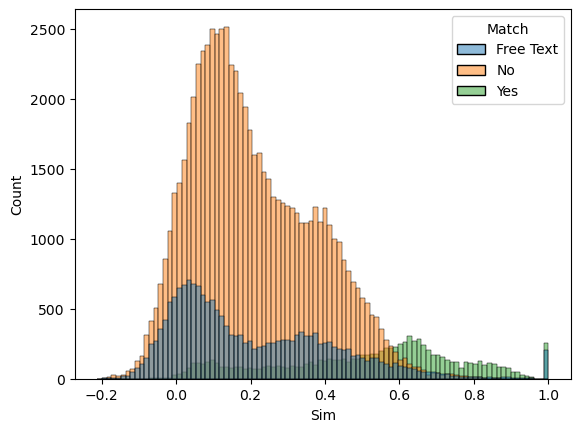

In [347]:
sns.histplot(data=df_sub2,x='Sim',hue='Match')

Explained variance ratio [0.1124194  0.07592465 0.05182851]


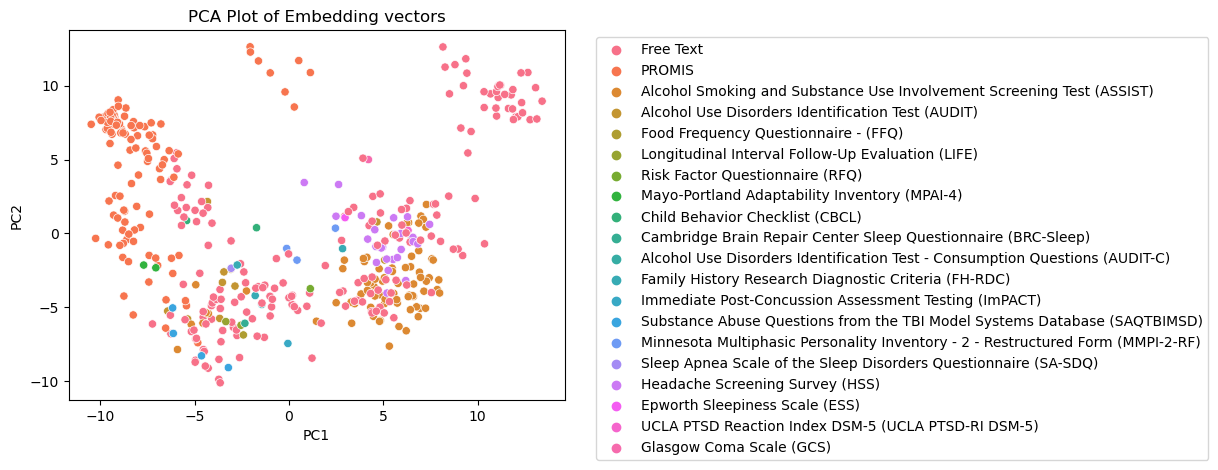

In [348]:
sc,df=plot_featurized_images(embeddings2,params={'hue':df_nih['Vocab']},df=df_nih.copy())

In [349]:
df_sub2 = df_sub2[(df_sub2['Sim']>0.6)&(df_sub2['Mod1']!=df_sub2['Mod2'])]
df_sub2.to_excel('NIAAA_CDE_sims.xlsx')

In [353]:
1-pairwise_distances(model.encode(['I have to work','What is my occupation','I am at my job']),metric='cosine')

array([[1.        , 0.4316746 , 0.61187625],
       [0.4316746 , 1.        , 0.5466315 ],
       [0.61187625, 0.5466315 , 1.        ]], dtype=float32)

In [354]:
len(df_sub),len(df_sub2)

(10294, 5527)

In [367]:
len(df_nih['Vocab'].unique())

20

In [369]:
df_sub2[df_sub2['Match']=='Yes'].head(10)

,Mod1,Mod2,Sim,ModName_x,Vocab_x,ModName_y,Vocab_y,Match
22,Alcohol use had craving for alcohol scale,Alcohol use alcohol other drug use together scale,0.675647,Alcohol use had craving for alcohol scale,PROMIS,Alcohol use alcohol other drug use together scale,PROMIS,Yes
222,Alcoholic beverage frequency,Alcoholic beverage indicator,0.698066,Alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage indicator,Alcohol Smoking and Substance Use Involvement ...,Yes
243,Alcoholic beverage frequency,Alcoholic beverage concern indicator,0.656759,Alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage concern indicator,Alcohol Smoking and Substance Use Involvement ...,Yes
251,Alcoholic beverage indicator,Alcoholic beverage concern indicator,0.911224,Alcoholic beverage indicator,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage concern indicator,Alcohol Smoking and Substance Use Involvement ...,Yes
265,Alcoholic beverage frequency,Desire alcoholic beverage frequency,0.872705,Alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Desire alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Yes
273,Alcoholic beverage indicator,Desire alcoholic beverage frequency,0.658440,Alcoholic beverage indicator,Alcohol Smoking and Substance Use Involvement ...,Desire alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Yes
274,Alcoholic beverage concern indicator,Desire alcoholic beverage frequency,0.618128,Alcoholic beverage concern indicator,Alcohol Smoking and Substance Use Involvement ...,Desire alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Yes
290,Drink contain alcohol frequency score,Cannot stop drink alcohol frequency score,0.779351,Drink contain alcohol frequency score,Alcohol Use Disorders Identification Test (AUDIT),Cannot stop drink alcohol frequency score,Alcohol Use Disorders Identification Test (AUDIT),Yes
314,Drink contain alcohol frequency score,Alcohol drink typical day number score,0.740677,Drink contain alcohol frequency score,Alcohol Use Disorders Identification Test (AUDIT),Alcohol drink typical day number score,Alcohol Use Disorders Identification Test (AUDIT),Yes
337,Alcoholic beverage frequency,Alcoholic beverage problem frequency,0.892495,Alcoholic beverage frequency,Alcohol Smoking and Substance Use Involvement ...,Alcoholic beverage problem frequency,Alcohol Smoking and Substance Use Involvement ...,Yes
